<a href="https://colab.research.google.com/github/KatHaruto/PINNs_example/blob/main/SFHCPINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

difference between $SFHCPINN_{NN}$ and $SFHCPINN$ is whether distance function adn extension functino are numerically determined , or computed using NN that trained before PINNs training.

In [3]:
import sys
sys.version

'3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]'

In [4]:
from functools import partial
from abc import ABC, abstractmethod
from typing import Literal,TypeAlias, Protocol, Callable # type alias statement requires Python 3.12 or newer
import warnings

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from scipy.stats import qmc


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:


SAMPLING_STRATEGY: TypeAlias = Literal["uniform", "LHS", "Sobol"] # todo: "adaptive"


In [8]:
class Problem(ABC):
  def __init__():
    pass

  @abstractmethod
  def pde_residual():
    raise NotImplementedError

class NeumannProblem(Problem):
  def __init__(self):
    pass

  @abstractmethod
  def bc_residual():
    raise NotImplementedError

In [9]:
class DirichletADE1D(Problem):
  def __init__(self, alpha:float = 0.1, beta:float = 30, p: float = 0.02, q: float = 0.01) -> None:
    self.alpha = alpha
    self.beta = beta
    self.p = p
    self.q = q

  def analytical_u(self, X: torch.Tensor):
    x, t = X[:,0:1], X[:,1:2]
    return torch.exp(-self.alpha * t) * (
        torch.sin(torch.pi * x) + 0.1 * torch.sin(self.beta * torch.pi * x)
    )

  def _analytical_du_dt(self, X: torch.Tensor) -> torch.Tensor:
    x, t = X[:,0:1], X[:,1:2]
    return -self.alpha * self.analytical_u(X)

  def _analytical_du_dx(self, X: torch.Tensor) -> torch.Tensor:
    x, t = X[:,0:1], X[:,1:2]
    return torch.exp(-self.alpha * t) * (
        torch.pi * torch.cos(torch.pi * x) + 0.1 * self.beta * torch.pi * torch.cos(self.beta * torch.pi * x)
    )

  def _analytical_d2u_dx2(self, X: torch.Tensor) -> torch.Tensor:
    x,t = X[:,0:1], X[:,1:2]
    return torch.exp(-self.alpha * t) * (
        - torch.pi**2 * torch.sin(torch.pi * x) - 0.1 * (self.beta * torch.pi)**2 * torch.sin(self.beta * torch.pi * x))

  def source_function(self, X: torch.Tensor) -> torch.Tensor:
    return self._analytical_du_dt(X) - self.p * self._analytical_d2u_dx2(X) + self.q * self._analytical_du_dx(X)

  def initial_condition(self, X: torch.Tensor) -> torch.Tensor:
    pass

  def boundary_condition(self, X: torch.Tensor) -> torch.Tensor:
    pass

  def pde_residual(self, u: torch.Tensor, X:torch.Tensor) -> torch.Tensor:

    assert u.shape[1] == 1
    assert X.shape[1] == 2

    grad_u = torch.autograd.grad(u, X, torch.ones_like(u), create_graph=True,retain_graph=True)[0]
    du_dx = grad_u[:,0:1]
    du_dt = grad_u[:,1:2]

    # 2次微分
    d2u_dx2 = torch.autograd.grad(du_dx, X, torch.ones_like(du_dx), create_graph=True,retain_graph=True)[0][:,0:1]

    S_val = self.source_function(X)

    # PDE残差
    res = du_dt - self.p * d2u_dx2 + self.q * du_dx - S_val

    return res

In [10]:
class NeumannADE1D(NeumannProblem):
  def __init__(self, alpha:float = 0.25, beta:float = 10, p: float = 0.002, q: float = 0.001) -> None:
    self.alpha = alpha
    self.beta = beta
    self.p = p
    self.q = q

  def analytical_u(self, X: torch.Tensor):
    x, t = X[:,0:1], X[:,1:2]
    return torch.exp(-self.alpha * t) * (
        torch.sin(torch.pi * x) + 0.1 * torch.sin(self.beta * torch.pi * x)
    )

  def _analytical_du_dt(self, X: torch.Tensor) -> torch.Tensor:
    x, t = X[:,0:1], X[:,1:2]
    return -self.alpha * self.analytical_u(X)

  def _analytical_du_dx(self, X: torch.Tensor) -> torch.Tensor:
    x, t = X[:,0:1], X[:,1:2]
    return torch.exp(-self.alpha * t) * (
        torch.pi * torch.cos(torch.pi * x) + 0.1 * self.beta * torch.pi * torch.cos(self.beta * torch.pi * x)
    )

  def _analytical_d2u_dx2(self, X: torch.Tensor) -> torch.Tensor:
    x,t = X[:,0:1], X[:,1:2]
    return torch.exp(-self.alpha * t) * (
        - torch.pi**2 * torch.sin(torch.pi * x) - 0.1 * (self.beta * torch.pi)**2 * torch.sin(self.beta * torch.pi * x))

  def source_function(self, X: torch.Tensor) -> torch.Tensor:
    return self._analytical_du_dt(X) - self.p * self._analytical_d2u_dx2(X) + self.q * self._analytical_du_dx(X)

  def initial_condition(self, X: torch.Tensor) -> torch.Tensor:
    pass

  def bc_residual(self, u: torch.Tensor, X: torch.Tensor) -> torch.Tensor:
    du_dx = torch.autograd.grad(u, X, torch.ones_like(u), create_graph=True,retain_graph=True)[0][:,0:1]
    return du_dx - self._analytical_du_dx(X)

  def pde_residual(self, u: torch.Tensor, X:torch.Tensor) -> torch.Tensor:

    assert u.shape[1] == 1
    assert X.shape[1] == 2

    grad_u = torch.autograd.grad(u, X, torch.ones_like(u), create_graph=True,retain_graph=True)[0]
    du_dx = grad_u[:,0:1]
    du_dt = grad_u[:,1:2]

    # 2次微分
    d2u_dx2 = torch.autograd.grad(du_dx, X, torch.ones_like(du_dx), create_graph=True,retain_graph=True)[0][:,0:1]

    S_val = self.source_function(X)

    # PDE残差
    res = du_dt - self.p * d2u_dx2 + self.q * du_dx - S_val

    return res

In [11]:
class Sin(nn.Module):
  def __init__(self):
    super(Sin, self).__init__()
  def forward(self, x):
    return torch.sin(x)

class FourierFeatureLayer(nn.Module):
    def __init__(self,input_dim, hidden_size, k):
      super(FourierFeatureLayer, self).__init__()
      self.k = k
      self.w = nn.Linear(input_dim, hidden_size)

    def forward(self, x):
      x = self.w(self.k * x)
      return torch.cat([torch.cos(x), torch.sin(x)] , dim=1)

class PINN(nn.Module):
  def __init__(self, *, input_dim, output_dim, hidden_size_list):
    super(PINN, self).__init__()
    layers = []

    for hidden_size in hidden_size_list:
        layers.append(nn.Linear(input_dim, hidden_size))
        layers.append(Sin())
        input_dim = hidden_size
    layers.append(nn.Linear(input_dim, output_dim))

    self.layers = nn.Sequential(*layers)



  def forward(self, x):
    return self.layers(x)


class SFPINN(nn.Module):
  def __init__(self, *, input_dim, output_dim,  subn_hidden_size_list: list[list[int]], frequencies: list[int]):
    super(SFPINN, self).__init__()

    if len(subn_hidden_size_list) != len(frequencies):
      raise ValueError("subn_hidden_size_list and frequencies must have the same length")

    self.subnetworks = nn.ModuleList(
        [
            nn.Sequential(
              FourierFeatureLayer(
                  input_dim,
                  hidden_size_list[0],
                  freq
              ),
              PINN(
                input_dim=hidden_size_list[0] * 2,
                output_dim=output_dim,
                hidden_size_list=hidden_size_list[1:]
              )
            )
            for hidden_size_list,freq in zip(subn_hidden_size_list, frequencies)
        ]
    )

    self.w = nn.Linear(output_dim * len(frequencies), output_dim)



  def forward(self, x):
    out = torch.cat([subn(x) for subn in self.subnetworks], dim=1)
    return self.w(out)


class SFHCPINN(SFPINN):
  def __init__(
      self,
      *,
      input_dim: int,
      output_dim: int,
      subn_hidden_size_list: list[list[int]],
      frequencies: list[int],
      dist_func: Callable[[torch.tensor], torch.tensor],
      extension_func: Callable[[torch.tensor], torch.tensor],
    ):
    super(SFHCPINN, self).__init__(
        input_dim=input_dim,
        output_dim=output_dim,
        subn_hidden_size_list=subn_hidden_size_list,
        frequencies=frequencies
    )

    self.dist_func = dist_func
    self.extention_func = extension_func

  def forward(self, x):
    out = torch.cat([subn(x) for subn in self.subnetworks], dim=1)

    return self.extention_func(x) + self.dist_func(x) * self.w(out)



# one dimensional ADE

## Governing Equation
$$
\frac{\partial u(x,t)}{\partial t}  = \tilde{p} \frac{\partial^2u(x,t)}{\partial t} - \tilde{q} \frac{\partial u(x,t)}{\partial x} + f(x,t), for\,x \in [a,b]\, and\, t \in [t_0,T]
$$

### I/C and B/C
$$
u(x,t_0) = A_0(x), \\
u(a,t) = A_1(t), \\
u(b,t) = A_2(t), \\
\frac{\partial u(a,t)}{\partial x} = N_1(t), \\
\frac{\partial u(b,t)}{\partial x} = N_2(t)
$$

### Solution is folloing equation
$$
u(x,t) =  e^{-\alpha t}[sin(\pi x) + 0.1 sin(\beta \pi x)]
$$

In [35]:
epoch = 50_000
N_r = 8_000
N_b = 3_000

## SFHCPINN does not need initial/boundary points.
# N_b = 4_000
# N_i = 3_000

initial_lr = 0.01
decay_rate = 0.975
decay_step_size = 100

gamma_0 = 20




In [13]:
class BaseSampler(ABC):
  def __init__(self,dim: int): pass

  @abstractmethod
  def sample(self, boundary: np.ndarray, num) -> np.ndarray:
    raise NotImplementedError

class UniformSampler(BaseSampler):
  def __init__(self,dim) -> None:
    self.dim = dim

  def sample(self, boundary:np.ndarray, num:int) -> np.ndarray:
    return np.random.uniform(size=(num, self.dim)) * (boundary[:,1] - boundary[:,0]) + boundary[:,0]


class LHSSampler(BaseSampler):
  def __init__(self,dim) -> None:
    self.dim = dim
    self.sampler = qmc.LatinHypercube(d=dim)

  def sample(self, boundary:np.ndarray, num:int) -> np.ndarray:
    return self.sampler.random(num) * (boundary[:,1] - boundary[:,0]) + boundary[:,0]

class SobolSampler(BaseSampler):
  def __init__(self,dim) -> None:
    self.dim = dim
    self.sampler = qmc.Sobol(d=dim, scramble=True)

  def sample(self, boundary:np.ndarray, num:int) -> np.ndarray:
    if not np.log2(num).is_integer():
      warnings.warn("number of samples should be power of 2")
    return self.sampler.random(num) * (boundary[:,1] - boundary[:,0]) + boundary[:,0]


In [36]:
def gen_sample(sampling_num:int, boundary: list, strategy: SAMPLING_STRATEGY) -> torch.Tensor:
  def _get_sampler(strategy: SAMPLING_STRATEGY, dim) -> BaseSampler:
    if strategy == "uniform":
      return UniformSampler(dim)
    if strategy == "LHS":
      return LHSSampler(dim)
    if strategy == "Sobol":
      return SobolSampler(dim)
    raise ValueError(f"Unknown sampling strategy: {strategy}")

  dim = len(boundary)
  return torch.from_numpy(_get_sampler(strategy, dim).sample(boundary, sampling_num)).to(torch.float)

In [37]:
def generate_collocation_data(N: int, boundary: np.ndarray, gen_sample_func: Callable[[int, np.ndarray], torch.Tensor]) -> torch.Tensor:
  return gen_sample_func(N, boundary)

def generate_boundary_data(N: int, boundary: np.ndarray, gen_sample_func: Callable[[int, np.ndarray], torch.Tensor]) -> torch.Tensor:
  _sample = gen_sample_func(N, boundary)
  boundary_t = torch.from_numpy(boundary).to(torch.float)

  _sample[..., :-1] = torch.where(_sample[..., :-1] < boundary_t.mean(dim=1)[:-1,...], boundary_t[:-1,0], boundary_t[:-1,1])
  return _sample

In [38]:
def compute_penalty(gamma_0, current_epoch, total_epoch):
  if current_epoch < 0.1 * total_epoch:
    return gamma_0
  if current_epoch < 0.2 * total_epoch:
    return 10 * gamma_0
  if current_epoch < 0.25 * total_epoch:
    return 50 * gamma_0
  if current_epoch < 0.5 * total_epoch:
    return 100 * gamma_0
  if current_epoch < 0.75 * total_epoch:
    return 200 * gamma_0
  return 500 * gamma_0

In [39]:
Model : TypeAlias = PINN | SFPINN | SFHCPINN
def train(problem: Problem, model: Model, boundary: np.ndarray, *, epoch=50000, optimizer=None, scheduler=None,sampling_stragtegy='uniform'):
  optimizer = optimizer or optim.Adam(model.parameters(), lr=initial_lr)
  scheduler = scheduler or optim.lr_scheduler.StepLR(optimizer, step_size=decay_step_size, gamma=decay_rate)

  gen_sample_func = partial(gen_sample, strategy=sampling_stragtegy)
  losses = []
  for e in tqdm(range(epoch)):
    model.train()
    optimizer.zero_grad()


    xt = generate_collocation_data(N_r, boundary, gen_sample_func).to(device).requires_grad_(True)
    u = model(xt)

    if isinstance(problem, NeumannProblem):

      xt_bc = generate_boundary_data(N_b, boundary, gen_sample_func).to(device).requires_grad_(True)
      u_bc = model(xt_bc)
      res = problem.pde_residual(u,xt)
      bc_res = problem.bc_residual(u_bc, xt_bc)
      loss = torch.mean(res ** 2) + compute_penalty(gamma_0, e, epoch) * torch.mean(bc_res ** 2)

    elif isinstance(problem, Problem):
      res = problem.pde_residual(u,xt)
      loss = torch.mean(res ** 2)

    else:
      raise ValueError("problem should be NeumannProblem or Problem.")



    loss.backward()

    optimizer.step()
    scheduler.step()
    losses.append(loss.item())

    if e % 1000 == 0:
      with torch.no_grad():
        test_xt = generate_collocation_data(10_000, boundary,gen_sample_func).to(device)
        u_pred = model(test_xt)

        u_true = problem.analytical_u(test_xt)

        mse = torch.mean((u_pred - u_true) ** 2)
        rel = ((u_pred - u_true)**2).sum() / (u_true ** 2).sum()

        print(f"epoch: {e}, learning_rate: {optimizer.param_groups[0]['lr']:.5g}, loss: {loss.item():.5g} MSE: {mse.item():.5g} REL: {rel.item():.5g}")



  return losses




In [105]:
# def source_fn(xt):
#     return du_dt(xt) - p_hat * d2u_dx2(xt) + q_hat * du_dx(xt)

# def pde_residual(u,X, current_epoch):
#     #X_pde = X
#     # X_pde = X.clone().detach().requires_grad_(True)
#     grad_u = torch.autograd.grad(u, X, torch.ones_like(u), create_graph=True,retain_graph=True)[0]
#     du_dx = grad_u[:,0:1]
#     du_dt = grad_u[:,1:2]

#     # 2次微分
#     d2u_dx2 = torch.autograd.grad(du_dx, X, torch.ones_like(du_dx), create_graph=True,retain_graph=True)[0][:,0:1]

#     S_val = source_fn(X)

#     # PDE残差
#     res = du_dt - p_hat * d2u_dx2 + q_hat * du_dx - S_val

#     return res



In [46]:
number_of_subnetworks = 20
boundary = np.array([[0.,2.],[0.,5.]])
def D(xt):
  x,t = xt[:,0:1], xt[:,1:2]
  return x * (2-x) * t / ( 5 * 2**2)

def G(xt,beta):
  x,t = xt[:,0:1], xt[:,1:2]
  return torch.sin(torch.pi * x) + 0.1 * torch.sin(beta * torch.pi * x)


# model = PINN(input_dim=2,output_dim=1, hidden_size_list=[100,150,80,80,50])

problem = DirichletADE1D()
extention_func = partial(G, beta=problem.beta)

model = SFHCPINN(
    input_dim=2,
    output_dim=1,
    subn_hidden_size_list=[[10,25,20,20,10] for _ in range(number_of_subnetworks)],
    frequencies=list(range(1,21)),
    dist_func=D,
    extension_func=extention_func
)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=initial_lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=decay_step_size, gamma=decay_rate)

train(problem, model, boundary, epoch=epoch, optimizer=optimizer, scheduler=scheduler, sampling_stragtegy="uniform")

  0%|          | 2/50000 [00:00<2:11:10,  6.35it/s]

epoch: 0, learning_rate: 0.01, loss: 9.3076 MSE: 0.030787 REL: 0.095828


  2%|▏         | 1002/50000 [02:59<2:03:51,  6.59it/s]

epoch: 1000, learning_rate: 0.0077633, loss: 9.1612 MSE: 0.035112 REL: 0.10746


  4%|▍         | 2001/50000 [05:33<2:35:16,  5.15it/s]

epoch: 2000, learning_rate: 0.0060269, loss: 9.0127 MSE: 0.011369 REL: 0.035578


  6%|▌         | 3002/50000 [08:14<1:51:45,  7.01it/s]

epoch: 3000, learning_rate: 0.0046788, loss: 1.0894 MSE: 0.0010971 REL: 0.0034188


  7%|▋         | 3517/50000 [09:41<2:08:05,  6.05it/s]


KeyboardInterrupt: 

In [ ]:
number_of_subnetworks = 20
boundary = np.array([[0.,1.],[0.,1.]])
def D(xt):
  x,t = xt[:,0:1], xt[:,1:2]
  return x * (1-x) * t

def G(xt):
  x,t = xt[:,0:1], xt[:,1:2]
  return torch.sin(x)


# model = PINN(input_dim=2,output_dim=1, hidden_size_list=[100,150,80,80,50])

problem = NeumannADE1D()

model = SFHCPINN(
    input_dim=2,
    output_dim=1,
    subn_hidden_size_list=[[10,25,20,20,10] for _ in range(number_of_subnetworks)],
    frequencies=list(range(1,21)),
    dist_func=D,
    extension_func=G
)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=initial_lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=decay_step_size, gamma=decay_rate)

train(problem, model, boundary, epoch=epoch, optimizer=optimizer, scheduler=scheduler, sampling_stragtegy="uniform")

  0%|          | 1/50000 [00:01<24:05:10,  1.73s/it]

epoch: 0, learning_rate: 0.01, loss: 197.85 MSE: 0.13056 REL: 0.32947


  0%|          | 60/50000 [00:14<4:01:42,  3.44it/s]

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/model_neu1dade.pth")

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/model.pth"))

In [107]:
# # plot
# import matplotlib.pyplot as plt

# xt = generate_collocation_data(N_r, boundary,partial(gen_sample, strategy='Sobol'))
# xx,tt = torch.meshgrid(xt[:,0],xt[:,1])
# d = D(xt).unsqueeze(0).detach().cpu().numpy()
# plt.scatter(xt[:,0],xt[:,1], c=d)
# plt.colorbar()
# plt.xlabel('x')
# plt.ylabel('t')
# plt.title('D(x,t)')
# plt.show()

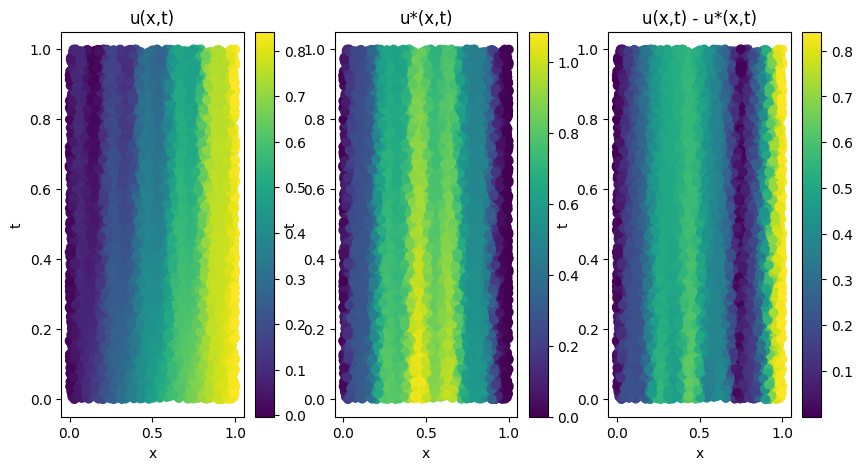

In [108]:
import matplotlib.pyplot as plt

with torch.no_grad():
  xt = generate_collocation_data(10_000, boundary,partial(gen_sample, strategy='uniform'))

  u_pred = model(xt.to(device)).detach().cpu().numpy()
  u_true = problem.analytical_u(xt).detach().cpu().numpy()
  abs_diff = np.abs(u_true-u_pred)

  fig = plt.figure(figsize=(10, 5))
  ax1 = fig.add_subplot(1,3,1)
  sc = ax1.scatter(xt[:,0],xt[:,1], c=u_pred)
  ax1.set_xlabel('x')
  ax1.set_ylabel('t')
  ax1.set_title('u(x,t)')

  plt.colorbar(sc, ax=ax1)
  # plt.colorbar(

  ax2 = fig.add_subplot(1,3,2)
  sc = ax2.scatter(xt[:,0],xt[:,1], c=u_true)
  # ax2.colorbar()
  ax2.set_xlabel('x')
  ax2.set_ylabel('t')
  ax2.set_title('u*(x,t)')

  plt.colorbar(sc, ax=ax2)

  ax3 = fig.add_subplot(1,3,3)

  sc = ax3.scatter(xt[:,0],xt[:,1], c=abs_diff)
  # ax3.colorbar()
  ax3.set_xlabel('x')
  ax3.set_ylabel('t')
  ax3.set_title('u(x,t) - u*(x,t)')

  plt.colorbar(sc, ax=ax3)
  plt.show()



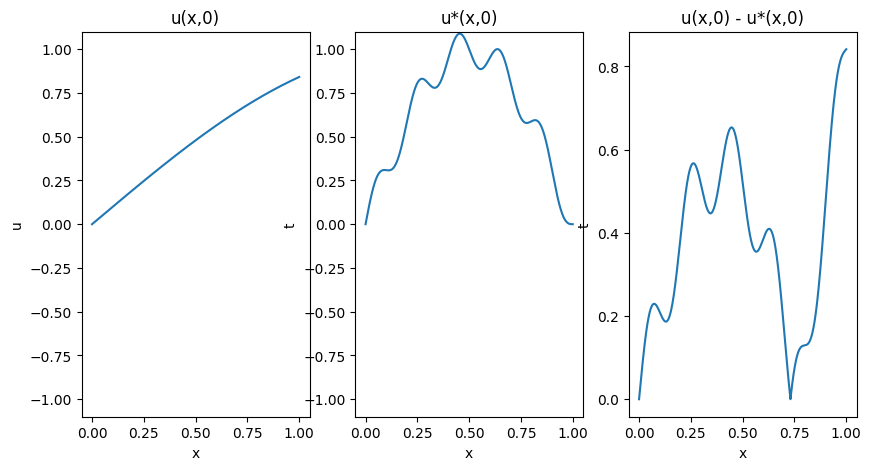

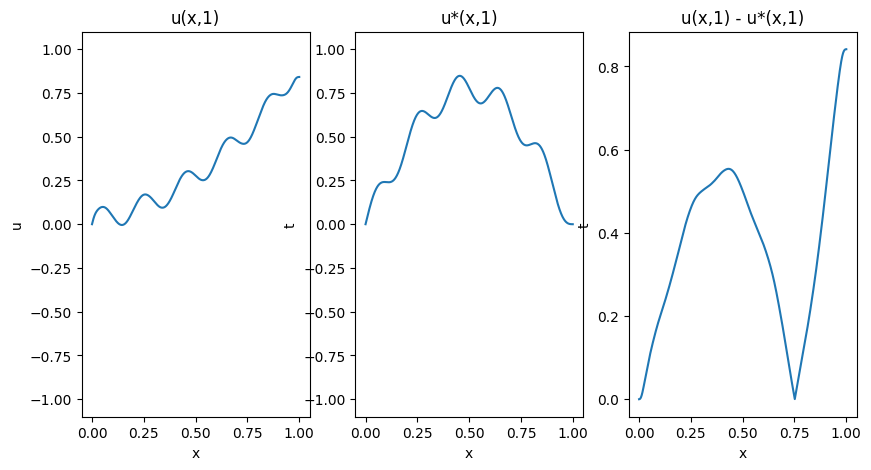

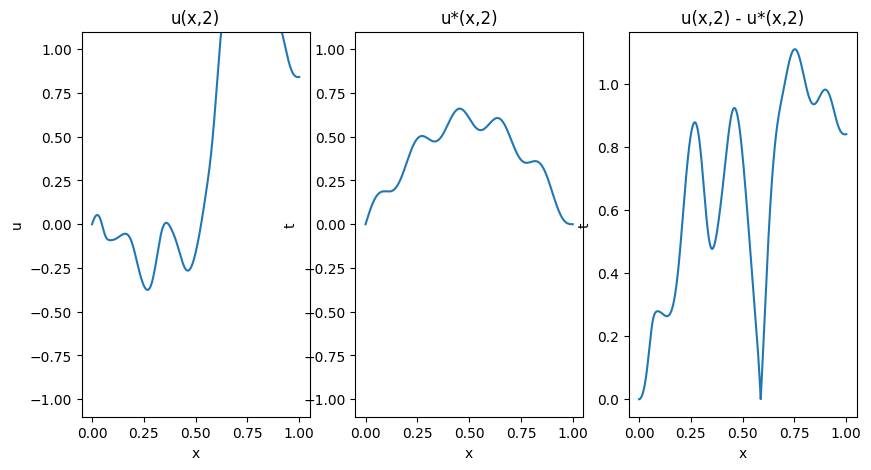

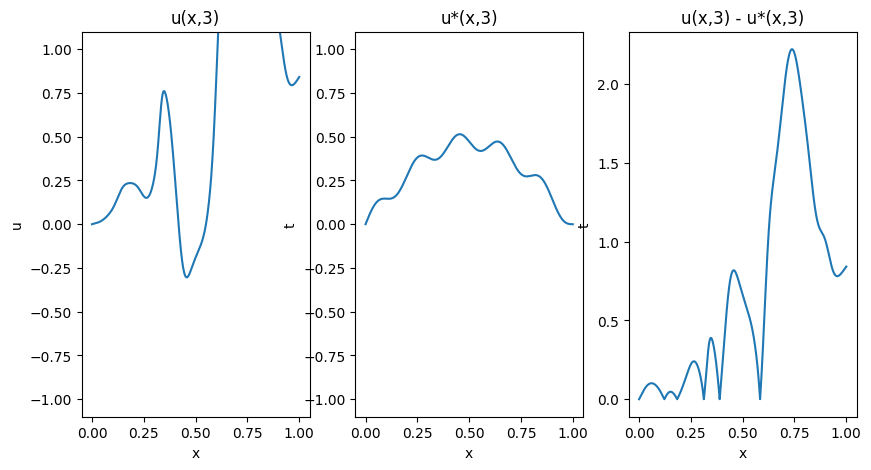

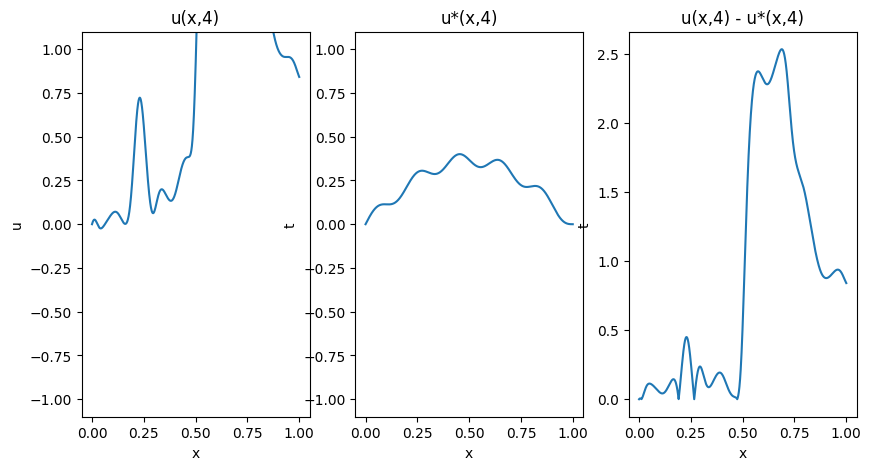

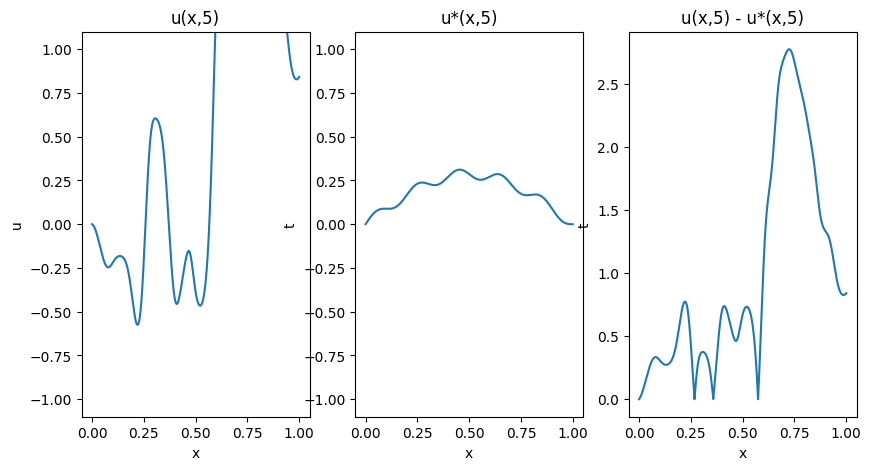

In [109]:
def visualize(model):
  with torch.no_grad():
    xt_eval = generate_collocation_data(10_000, boundary,partial(gen_sample, strategy='uniform'))
    # sort
    xt_eval, _ = xt_eval.sort(dim=0)
    for ti in range(6):
      xt_eval[:,1] = ti * torch.ones(xt_eval.shape[0])

      u_pred = model(xt_eval.to(device)).detach().cpu().numpy()
      u_true = problem.analytical_u(xt_eval).detach().cpu().numpy()
      abs_diff = np.abs(u_true-u_pred)
      fig = plt.figure(figsize=(10, 5))


      ax1 = fig.add_subplot(1,3,1)
      ax1.plot(xt_eval[:,0], u_pred)
      ax1.set_xlabel('x')
      ax1.set_ylabel('u')
      ax1.set_ylim(-1.1,1.1)
      ax1.set_title(f'u(x,{ti})')

      #plt.colorbar(sc, ax=ax1)
      # plt.colorbar(

      ax2 = fig.add_subplot(1,3,2)
      ax2.plot(xt_eval[:,0], u_true)
      # ax2.colorbar()
      ax2.set_xlabel('x')
      ax2.set_ylabel('t')
      ax2.set_ylim(-1.1,1.1)
      ax2.set_title(f'u*(x,{ti})')


      ax3 = fig.add_subplot(1,3,3)

      ax3.plot(xt_eval[:,0], abs_diff)
      # ax3.colorbar()
      ax3.set_xlabel('x')
      ax3.set_ylabel('t')
      ax3.set_title(f'u(x,{ti}) - u*(x,{ti})')

      plt.show()

visualize(model)